In [1]:
from pathlib import Path
from typing import Union

import pandas as pd
import torch
from cryptography.hazmat.primitives.keywrap import aes_key_wrap
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchmetrics
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk, DatasetDict, load_dataset, Dataset
import torchaudio
import random

SEED = 42
SAMPLE_RATE = 16000
BATCH_SIZE = 32
NUM_WORKERS = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

/home/pierre/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Dataset from huggingface of drones/others
ds = load_dataset("Usernameeeeee/df_462700_2")

In [4]:
LABELS = ds["train"].features["label"]

ds_split = ds["train"].train_test_split(test_size=0.3, seed=SEED)
test_and_valid = ds_split["test"].train_test_split(test_size=0.5, seed=SEED)

ds = DatasetDict({
    "train": ds_split["train"],
    "valid": test_and_valid["train"],
    "test": test_and_valid["test"],
})

print("Dataset splits:", {k: v.shape for k, v in ds.items()})
print("Label names:", LABELS.names)

Dataset splits: {'train': (323890, 3), 'valid': (69405, 3), 'test': (69406, 3)}
Label names: ['other', 'drone']


In [5]:
# Preprocessing
# We are doing :
# - Convert stereo to mono
# - Melspectogram
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64,
)
db_transform = torchaudio.transforms.AmplitudeToDB()

def preprocess(item: Union[dict, torch.Tensor]):
    if isinstance(item, dict):
        audio = item["audio"]
        waveform = torch.tensor(audio).float()
    else:
        waveform = item

    # Convert stereo → mono
    if waveform.ndim > 1:
        waveform = waveform.mean(dim=0)

    mel = mel_transform(waveform)
    mel_db = db_transform(mel)

    return mel_db

In [6]:
def collate_fn(batch):
    xs = []
    ys = []

    for b in batch:
        mel_db = preprocess(b)
        xs.append(mel_db)
        ys.append(b["label"])

    # Pad to max length in batch
    max_len = max(x.shape[-1] for x in xs)
    xs_padded = torch.zeros((len(xs), 1, 64, max_len))
    for i, x in enumerate(xs):
        xs_padded[i, 0, :, :x.shape[-1]] = x

    return xs_padded, torch.tensor(ys)


train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(ds["valid"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [7]:
class AudioCNN2D(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = AudioCNN2D(n_classes=len(LABELS.names)).to(DEVICE)
print(model)

AudioCNN2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
metric_acc = torchmetrics.classification.MulticlassAccuracy(num_classes=len(LABELS.names)).to(DEVICE)

In [9]:
EPOCHS = 5
best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_acc = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_acc += metric_acc(out, y) * x.size(0)

    scheduler.step()
    train_loss /= len(ds["train"])
    train_acc = train_acc / len(ds["train"])

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc += metric_acc(out, y) * x.size(0)

    val_loss /= len(ds["valid"])
    val_acc = val_acc / len(ds["valid"])

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_2dcnn_clean.pt")
        print("✅ Saved new best model!")

Epoch 1/5 [Valid]: 100%|██████████| 2169/2169 [00:18<00:00, 120.01it/s]


Epoch 1/5 | Train Loss: 0.0909 | Train Acc: 0.9678 | Val Loss: 0.0373 | Val Acc: 0.9878
✅ Saved new best model!


Epoch 2/5 [Valid]: 100%|██████████| 2169/2169 [00:18<00:00, 115.18it/s]


Epoch 2/5 | Train Loss: 0.0381 | Train Acc: 0.9879 | Val Loss: 0.0275 | Val Acc: 0.9903
✅ Saved new best model!


Epoch 3/5 [Valid]: 100%|██████████| 2169/2169 [00:18<00:00, 118.31it/s]


Epoch 3/5 | Train Loss: 0.0288 | Train Acc: 0.9909 | Val Loss: 0.0237 | Val Acc: 0.9930
✅ Saved new best model!


Epoch 4/5 [Valid]: 100%|██████████| 2169/2169 [00:18<00:00, 118.61it/s]


Epoch 4/5 | Train Loss: 0.0230 | Train Acc: 0.9927 | Val Loss: 0.0178 | Val Acc: 0.9944
✅ Saved new best model!


Epoch 5/5 [Valid]: 100%|██████████| 2169/2169 [00:18<00:00, 119.15it/s]

Epoch 5/5 | Train Loss: 0.0183 | Train Acc: 0.9939 | Val Loss: 0.0170 | Val Acc: 0.9946
✅ Saved new best model!


In [10]:
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        preds = out.argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

Testing: 100%|██████████| 2169/2169 [00:17<00:00, 125.96it/s]


              precision    recall  f1-score   support

       other      0.995     0.995     0.995     38272
       drone      0.994     0.993     0.994     31134

    accuracy                          0.994     69406
   macro avg      0.994     0.994     0.994     69406
weighted avg      0.994     0.994     0.994     69406



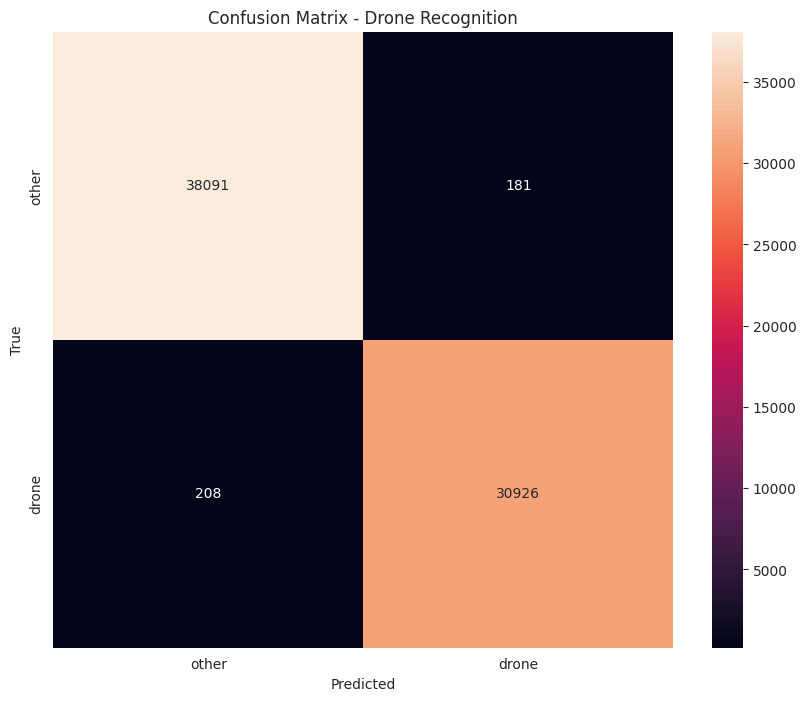

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, y_pred, target_names=LABELS.names, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS.names, yticklabels=LABELS.names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Drone Recognition")
plt.show()


In [12]:
def infer_from_waveform(model: nn.Module, waveform):
    mel_db: Tensor = preprocess(waveform)
    mel_db = mel_db.unsqueeze(0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(mel_db)
        pred_idx = out.argmax(dim=1).item()
        pred_label = LABELS.int2str(pred_idx)
        prob = torch.softmax(out, dim=1)[0, pred_idx].item()

    return pred_label, prob

def infer(model: nn.Module, path: str=None, audio_array=None, audio_decoder=None):
    # From a path
    if path:
        waveform, _ = torchaudio.load(path)
    # From dataset from huggingface
    elif audio_array is not None:
        waveform = torch.tensor(audio_array)
    elif audio_decoder is not None:
        waveform = torch.tensor(audio_decoder)
    else:
        raise NotImplemented

    return infer_from_waveform(model, waveform)

In [13]:
ds_test_local = load_dataset("audiofolder", data_dir="/home/pierre/Documents/Projects/PST4/AI/data/raw/test/")
ds_test_local = ds_test_local["train"]
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")

In [18]:
def infer_from_dataset(_model, _dataset: Union[Dataset, list], only_drone=False, show_resume=True, show_accuracy=True, title=None, highlight=None, labels=None):
    """
    :param _model: PyTorch model
    :param _dataset: A dataset or a list of (path, label)
    :param only_drone: If it only tests the drone
    :param show_resume:
    :param show_accuracy:
    :param title:
    :param highlight: Show the resume with colors
    :param labels: Labels of the list
    :return:
    """
    results = []

    is_dataset_list = isinstance(_dataset, list)
    # When dataset is a list, we pass the labels in parameters
    if not is_dataset_list:
        labels = _dataset.features["label"]


    for item in tqdm(_dataset, desc="Inference"):
        # Differents labels/infer calling, depending on the dataset : Dataset/List
        if not is_dataset_list:
            if only_drone and item["label"] != labels.str2int("drone"):
                continue
            pred_label, prob = infer(_model, audio_decoder=item["audio"]["array"])
            true_label = labels.int2str(item["label"])
        else:
            if only_drone and item[1] != "drone":
                continue
            pred_label, prob = infer(_model, path=item[0])
            true_label = item[1]

        results.append({
            "true_label": true_label,
            "pred_label": pred_label,
            "confidence": round(prob, 3),
            "correct": (pred_label == true_label)
        })

    df_results = pd.DataFrame(results)
    if title:
        print(title)
    if show_resume:
        print(df_results)
    if show_accuracy:
        accuracy = df_results["correct"].mean()
        print(f"✅ {"Drone" if only_drone else "Global"} accuracy on dataset: {accuracy*100:.2f}%")
    if highlight:
        display(df_results.style
            .background_gradient(subset=["confidence"], cmap="Blues")
            .applymap(lambda v: "background-color:#aaffaa" if v else "background-color:#ffaaaa", subset=["correct"])
        )

In [19]:
infer_from_dataset(model, ds_test_local, only_drone=True, show_accuracy=True, show_resume=False, title="Test Local Dataset")
# infer_from_dataset(ds_test_online, only_drone=False, show_accuracy=True, show_resume=False, title="Test Online Dataset")

Inference: 100%|██████████| 893/893 [00:00<00:00, 1995.82it/s]

Test Local Dataset
✅ Drone accuracy on dataset: 33.07%


In [258]:
base_dir = Path("/home/pierre/Documents/Projects/PST4/AI/data/raw/test/")
recordings = []
class_folders = ["drone", "other"]
for class_folder in class_folders:
    for file_path in (base_dir / class_folder).glob("*.wav"):
        recordings.append((str(file_path), class_folder))

infer_from_dataset(recordings, labels=class_folders, only_drone=False, show_accuracy=True, show_resume=False, title="Test Local Dataset")

Inference:   0%|          | 0/893 [00:00<?, ?it/s]/home/pierre/.local/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
Inference: 100%|██████████| 893/893 [00:00<00:00, 1531.91it/s]

Test Local Dataset
✅ Global accuracy on dataset: 70.77%
